# Time Series Analysis

A **time series** is a sequence of measurements from a system that varies in time.
Many of the tools we used in previous chapters, like regression, can also be used with time series.
But there are additional methods that are particularly useful for this kind of data.

As examples, we'll look at two datasets: renewable electricity generation in the United States from 2001 to 2024, and weather data over the same interval.
We will develop methods to decompose a time series into a long-term trend and a repeated seasonal component.
We'll use linear regression models to fit and forecast trends.
And we'll try out a widely-used model for analyzing time series data, with the formal name "autoregressive integrated moving average" and the easier-to-say acronym ARIMA.

The third edition of *Think Stats* is available now from [Bookshop.org](https://bookshop.org/a/98697/9781098190255) and [Amazon](https://amzn.to/42lmxwu) (those are affiliate links). If you are enjoying the free, online version, consider [buying me a coffee](https://buymeacoffee.com/allendowney).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap12.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

Downloaded thinkstats.py


In [2]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.9.0-py3-none-any.whl size=14296 sha256=62ae443d8f330defb745a6d150a7b8c8a3ba695529fa4b09ba3d804502074d17
  Stored in directory: /root/.cache/pip/wheels/96/04/f1/a934ef1f5f3db621dc39566b2c7de45b8c6916044be6a9c9ac
Successfully built empiricaldist


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

plt.rcParams["figure.dpi"] = 300

## Electricity

As an example of time-series data, we'll use a dataset from the U.S. Energy Information Administration -- it includes total electricity generation per month from renewable sources from 2001 to 2024.
Instructions for downloading the data are in the notebook for this chapter.

The following cell downloads the data, which I downloaded September 17, 2024 from https://www.eia.gov/electricity/data/browser/.

In [4]:
filename = "Net_generation_for_all_sectors.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

Downloaded Net_generation_for_all_sectors.csv


After loading the data, we have to make some transformations to get it into a format that's easy to work with.

In [5]:
elec = (
    pd.read_csv("Net_generation_for_all_sectors.csv", skiprows=4)
    .drop(columns=["units", "source key"])
    .set_index("description")
    .replace("--", np.nan)
    .transpose()
    .astype(float)
)

In the reformatted dataset, each column is a sequence of monthly totals in gigawatt-hours (GWh).
Here are the column labels, showing the different sources of electricity, or "sectors".

In [6]:
elec.columns

Index(['Net generation for all sectors', 'United States',
       'United States : all fuels (utility-scale)', 'United States : nuclear',
       'United States : conventional hydroelectric',
       'United States : other renewables', 'United States : wind',
       'United States : all utility-scale solar', 'United States : geothermal',
       'United States : biomass',
       'United States : hydro-electric pumped storage',
       'United States : all solar',
       'United States : small-scale solar photovoltaic'],
      dtype='object', name='description')

The labels in the index are strings indicating months and years -- here are the first 12.

In [7]:
elec.index[:12]

Index(['Jan 2001', 'Feb 2001', 'Mar 2001', 'Apr 2001', 'May 2001', 'Jun 2001',
       'Jul 2001', 'Aug 2001', 'Sep 2001', 'Oct 2001', 'Nov 2001', 'Dec 2001'],
      dtype='object')

It will be easier to work with this data if we replace these strings with Pandas `Timestamp` objects.
We can use the `date_range` function to generate a sequence of `Timestamp` objects, starting in January 2001 with the frequency code `"ME"`, which stands for "month end", so it fills in the last day of each month.

In [8]:
elec.index = pd.date_range(start="2001-01", periods=len(elec), freq="ME")
elec.index[:6]

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30'],
              dtype='datetime64[ns]', freq='ME')

Now the index is a `DataTimeIndex` with the data type `datetime64[ns]`, which is defined in NumPy -- `64` means each label uses 64 bits, and `ns` means it has nanosecond precision.

## Decomposition

As a first example, we'll look at how electricity generation from nuclear reactors changed over the interval from January 2001 to June 2024, and we'll decompose the time series into a long-term trend and a periodic component.
Here are monthly totals of electricity generation from nuclear reactors in the United States.

In [9]:
actual_options = dict(color="C0", lw=1, alpha=0.6)
trend_options = dict(color="C1", alpha=0.6)
pred_options = dict(color="C2", alpha=0.6, ls=':')
model_options = dict(color="gray", alpha=0.6, ls='--')

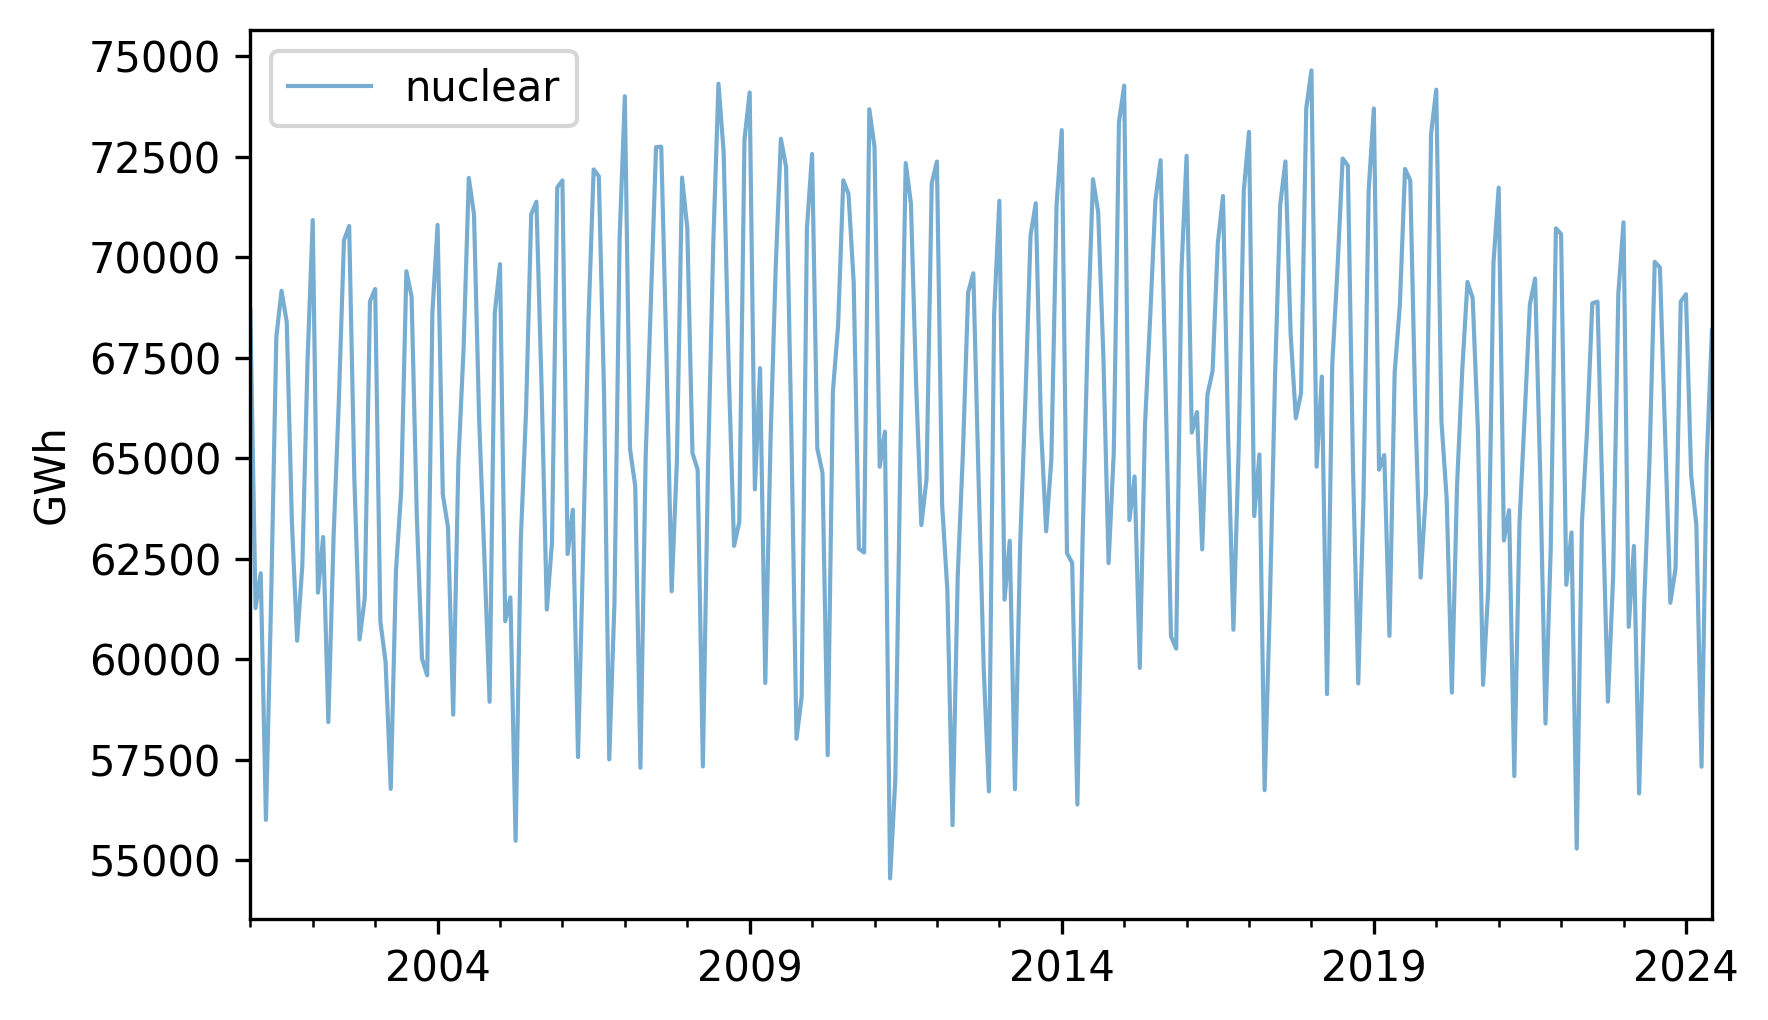

In [10]:
nuclear = elec["United States : nuclear"]
nuclear.plot(label="nuclear", **actual_options)

decorate(ylabel="GWh")

It looks like there are some increases and decreases, but they are hard to see clearly because there are large variations from month to month.
To see the long-term trend more clearly, we can use the `rolling` and `mean` methods to compute a **moving average**.

In [11]:
trend = nuclear.rolling(window=12).mean()

The `window=12` argument selects overlapping intervals of 12 months, so the first interval contains 12 measurements starting with the first, the second interval contains 12 measurements starting with the second, and so on.
For each interval, we compute the mean production.

Here's what the results look like, along with the original data.

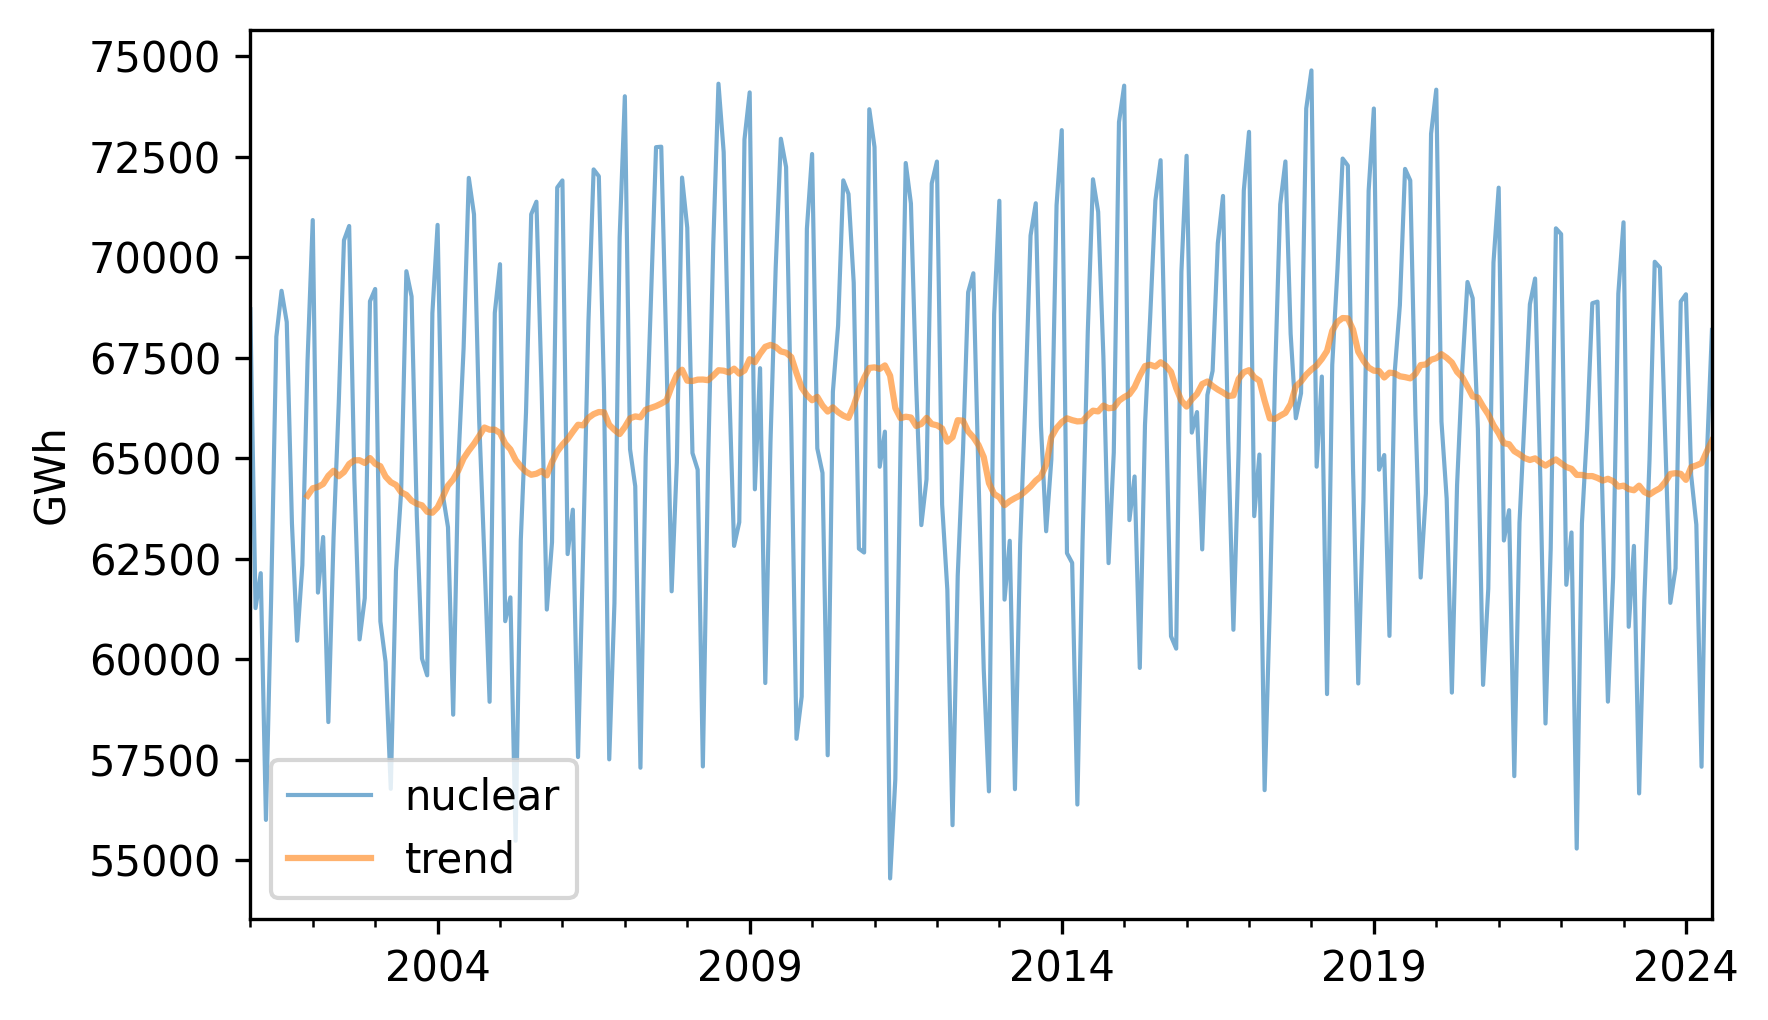

In [12]:
nuclear.plot(label="nuclear", **actual_options)
trend.plot(label="trend", **trend_options)
decorate(ylabel="GWh")

The trend is still quite variable.
We could smooth it more by using a longer window, but we'll stick with the 12-month window for now.

If we subtract the trend from the original data, the result is a "detrended" time series, which means that the long-term mean is close to constant.
Here's what it looks like.

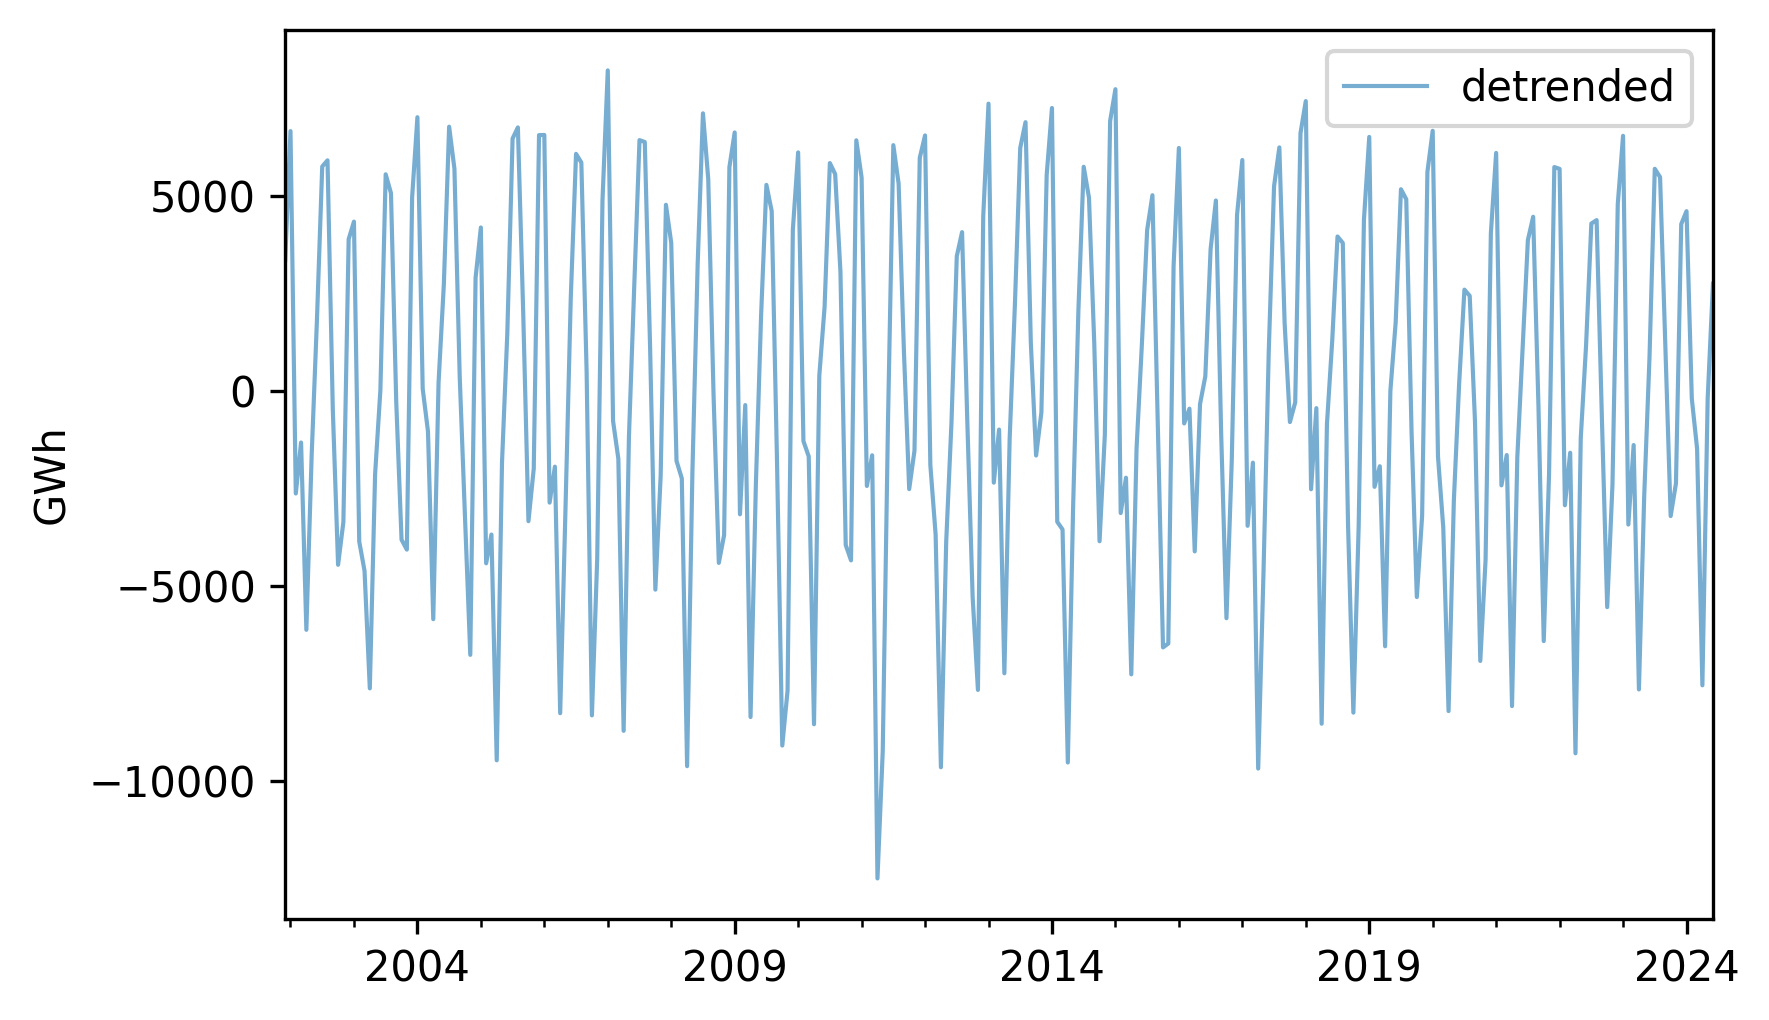

In [13]:
detrended = (nuclear - trend).dropna()
detrended.plot(label="detrended", **actual_options)
decorate(ylabel="GWh")

It seems like there is a repeating annual pattern, which makes sense because demand for electricity varies from one season to another, as it is used to generate heat in the winter and run air conditioning in the summer.
To describe this annual pattern we can select the month part of the `datetime` objects in the index, group the data by month, and compute average production.
Here's what the monthly averages look like.

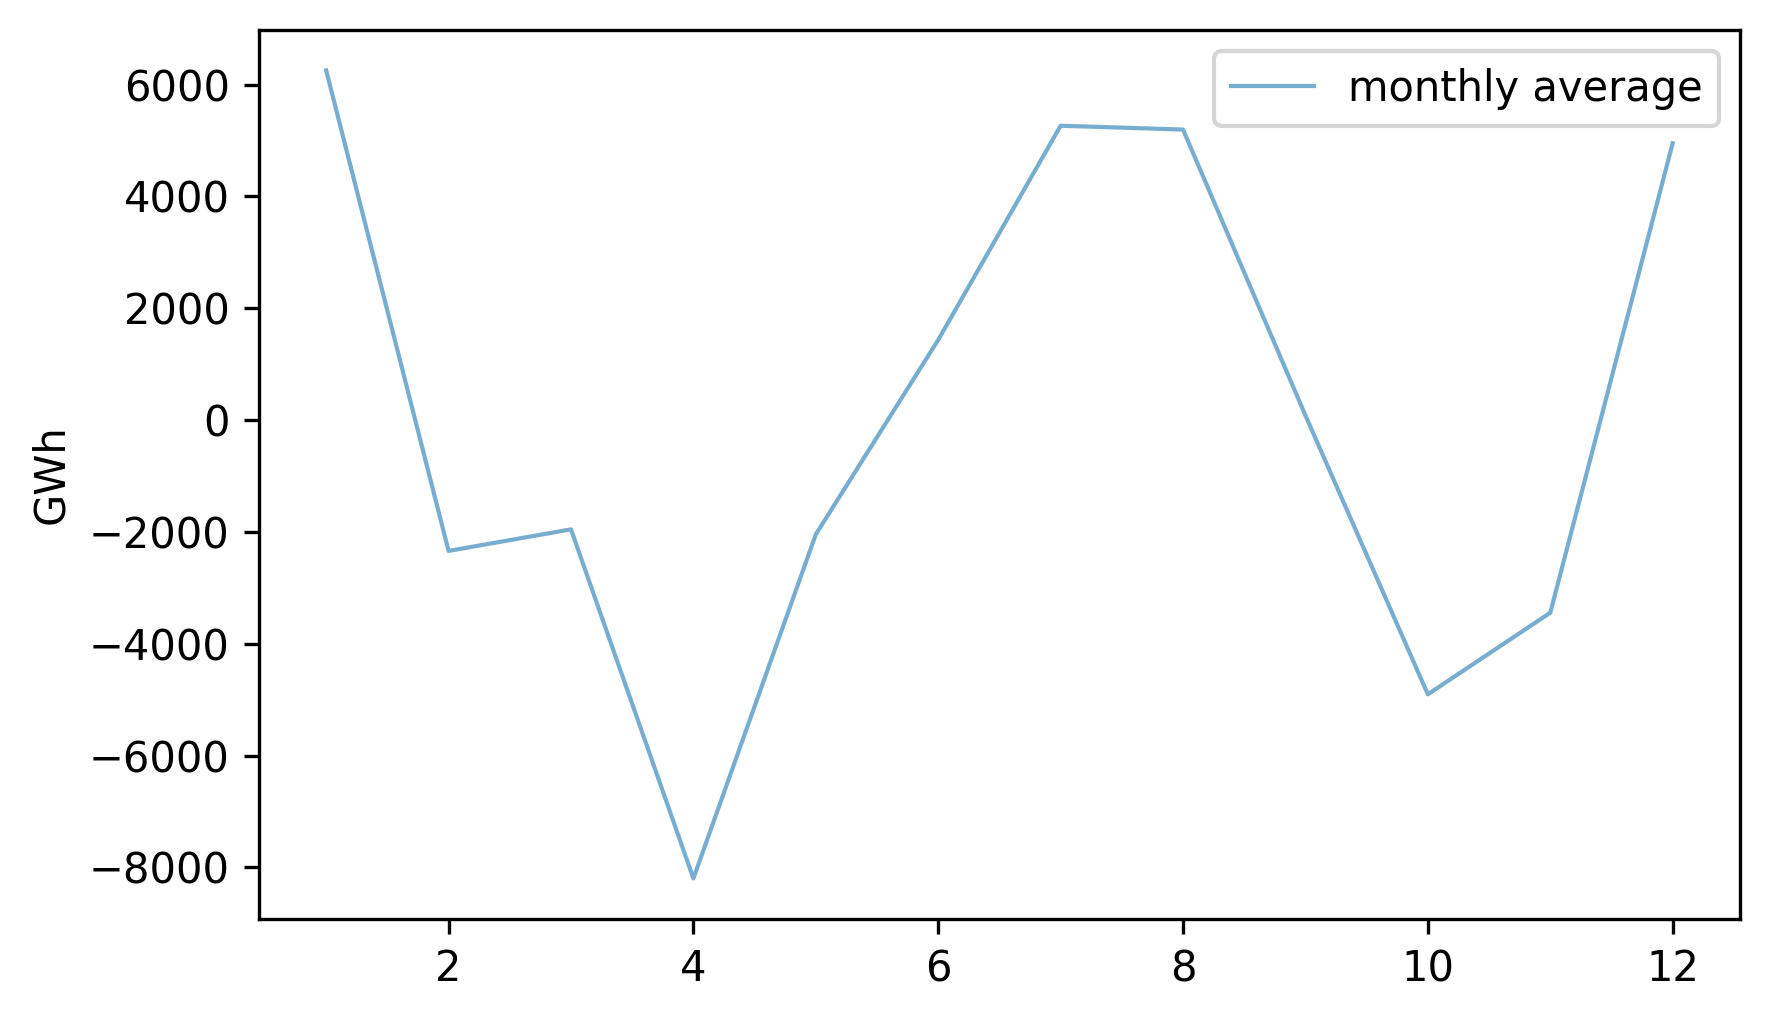

In [14]:
monthly_averages = detrended.groupby(detrended.index.month).mean()
monthly_averages.plot(label="monthly average", **actual_options)
decorate(ylabel="GWh")

On the x-axis, month 1 is January and month 12 is December.
Electricity production is highest during the coldest and warmest months, and lowest during April and October.

We can use `monthly_averages` to construct the seasonal component of the data, which is a series the same length as `nuclear`, where the element for each month is the average for that month.
Here's what it looks like.

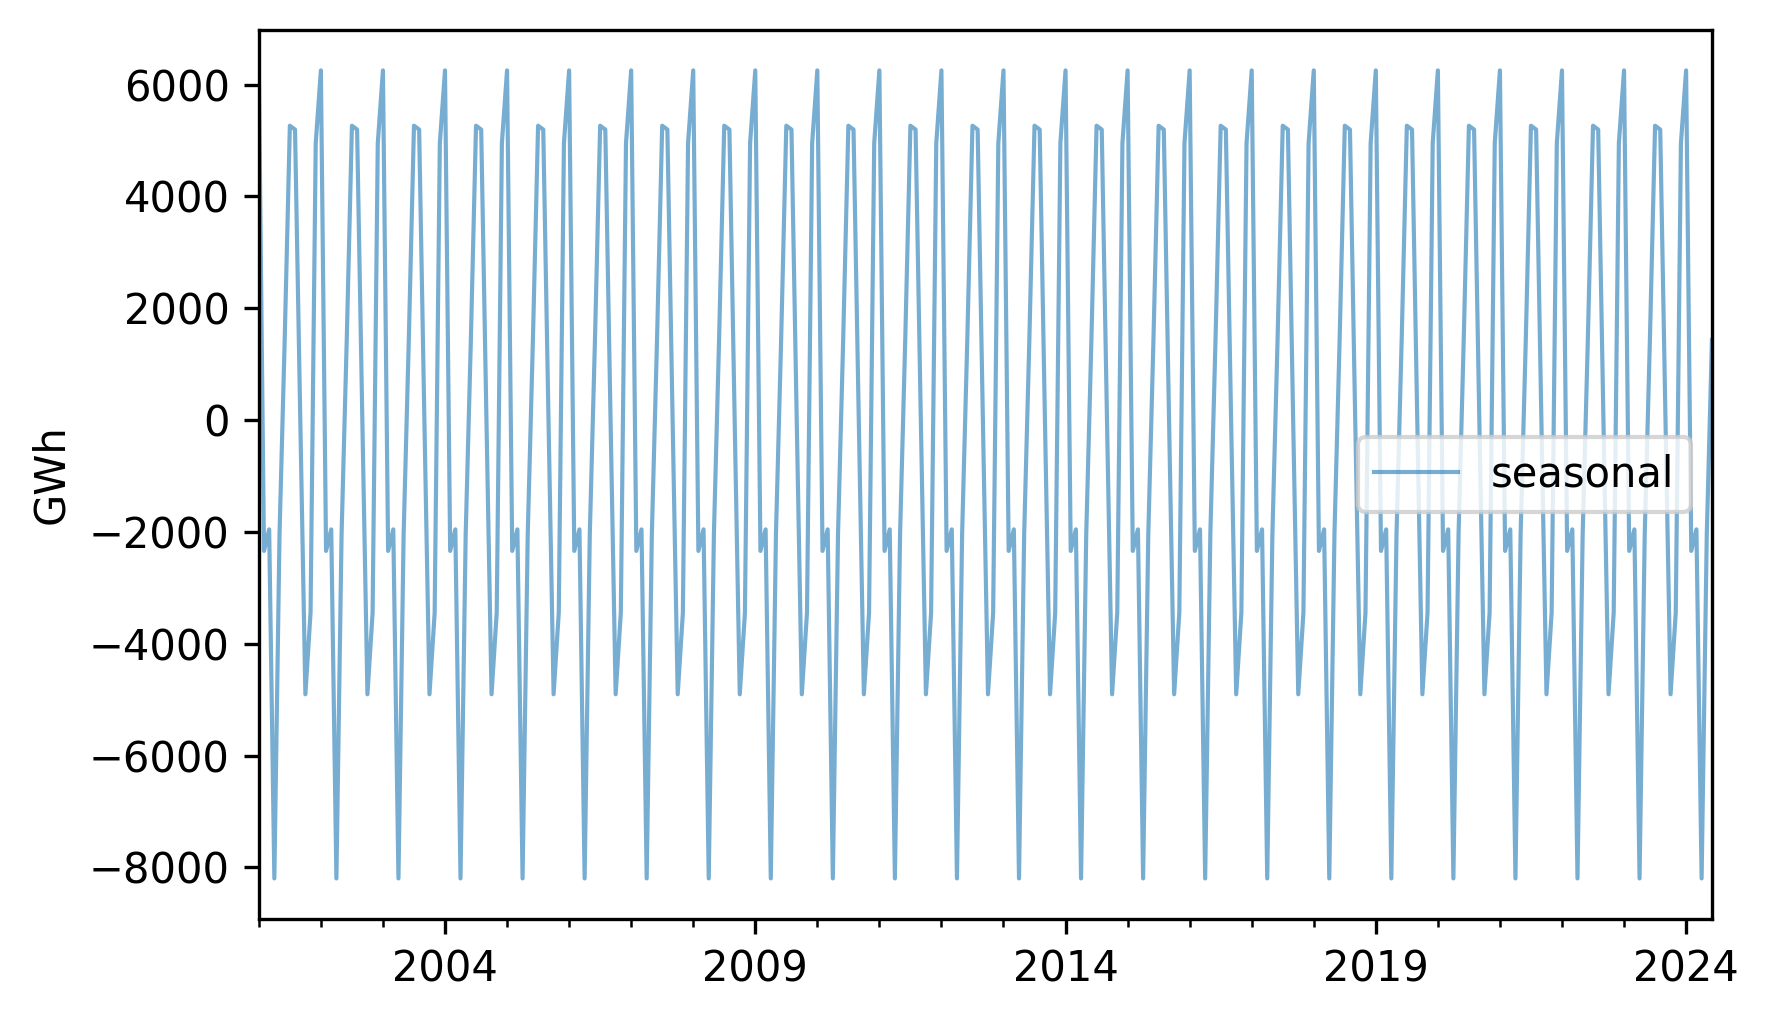

In [15]:
seasonal = monthly_averages[nuclear.index.month]
seasonal.index = nuclear.index
seasonal.plot(label="seasonal", **actual_options)
decorate(ylabel="GWh")

Each 12-month period is identical to the others.

The sum of the trend and the seasonal component represents the expected value for each month.

In [16]:
expected = trend + seasonal

Here's what it looks like compared to the original series.

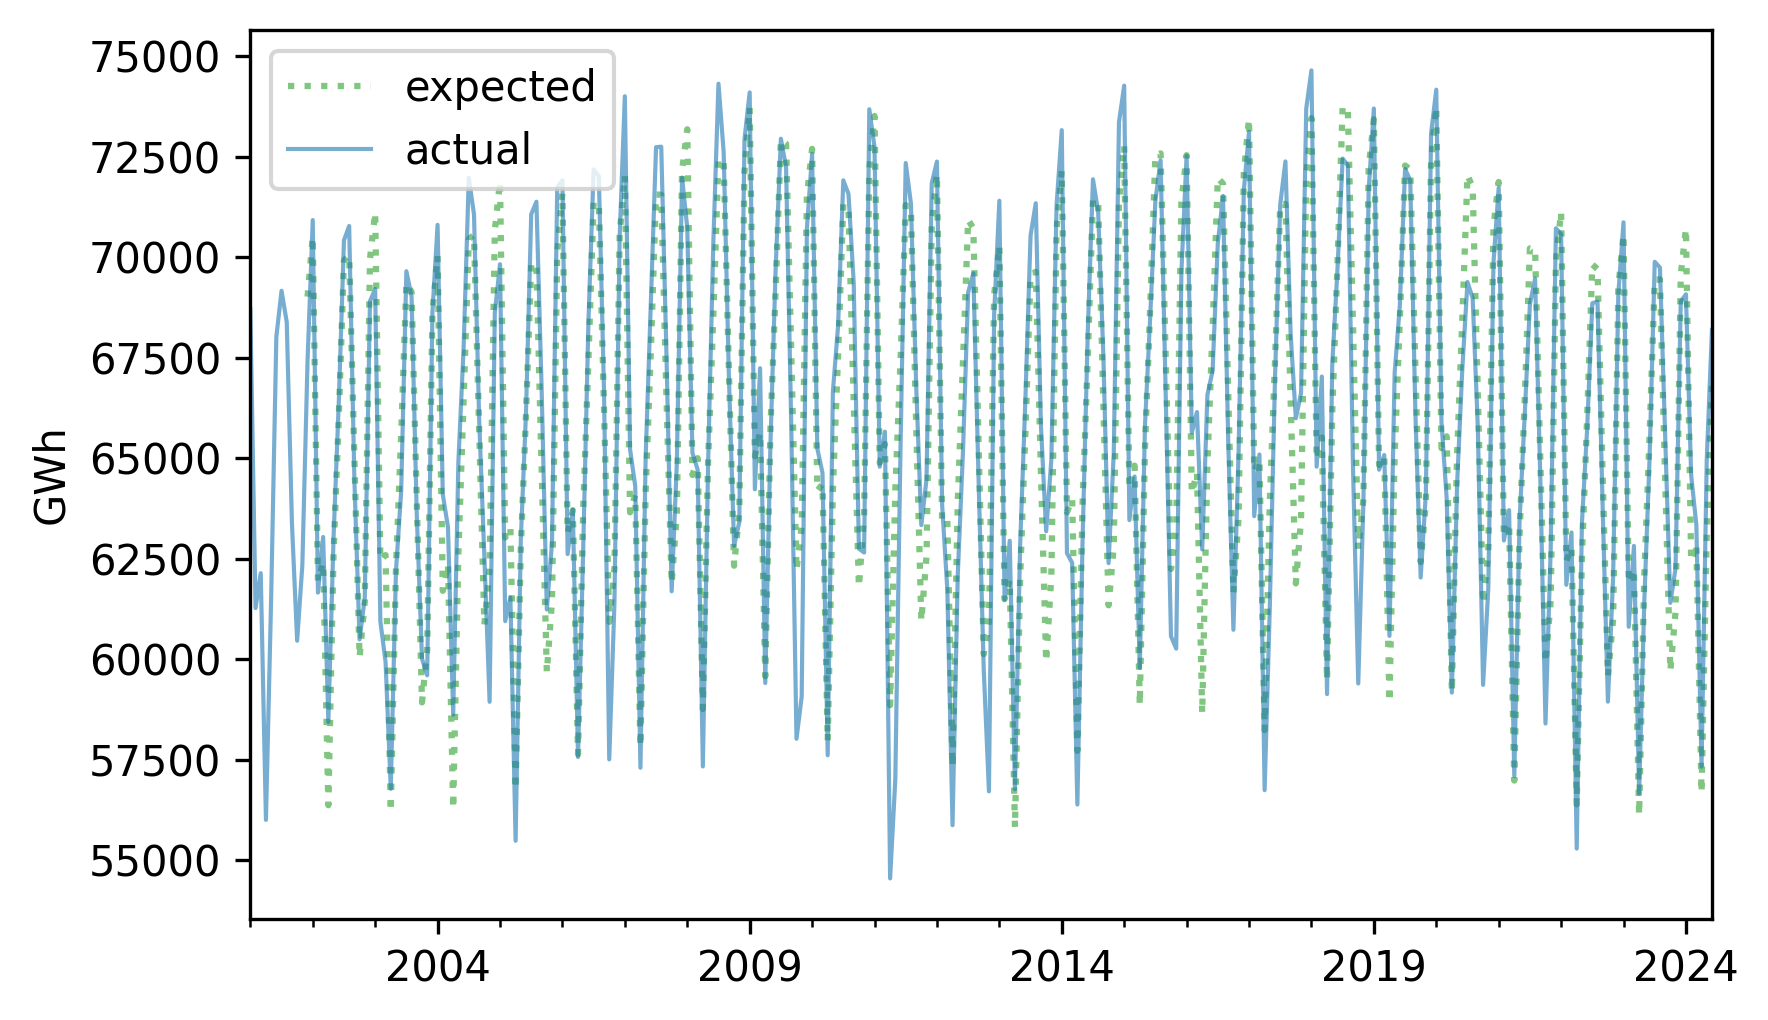

In [17]:
expected.plot(label="expected", **pred_options)
nuclear.plot(label="actual", **actual_options)
decorate(ylabel="GWh")

If we subtract this sum from the original series, the result is the residual component, which represents the departure from the expected value for each month.

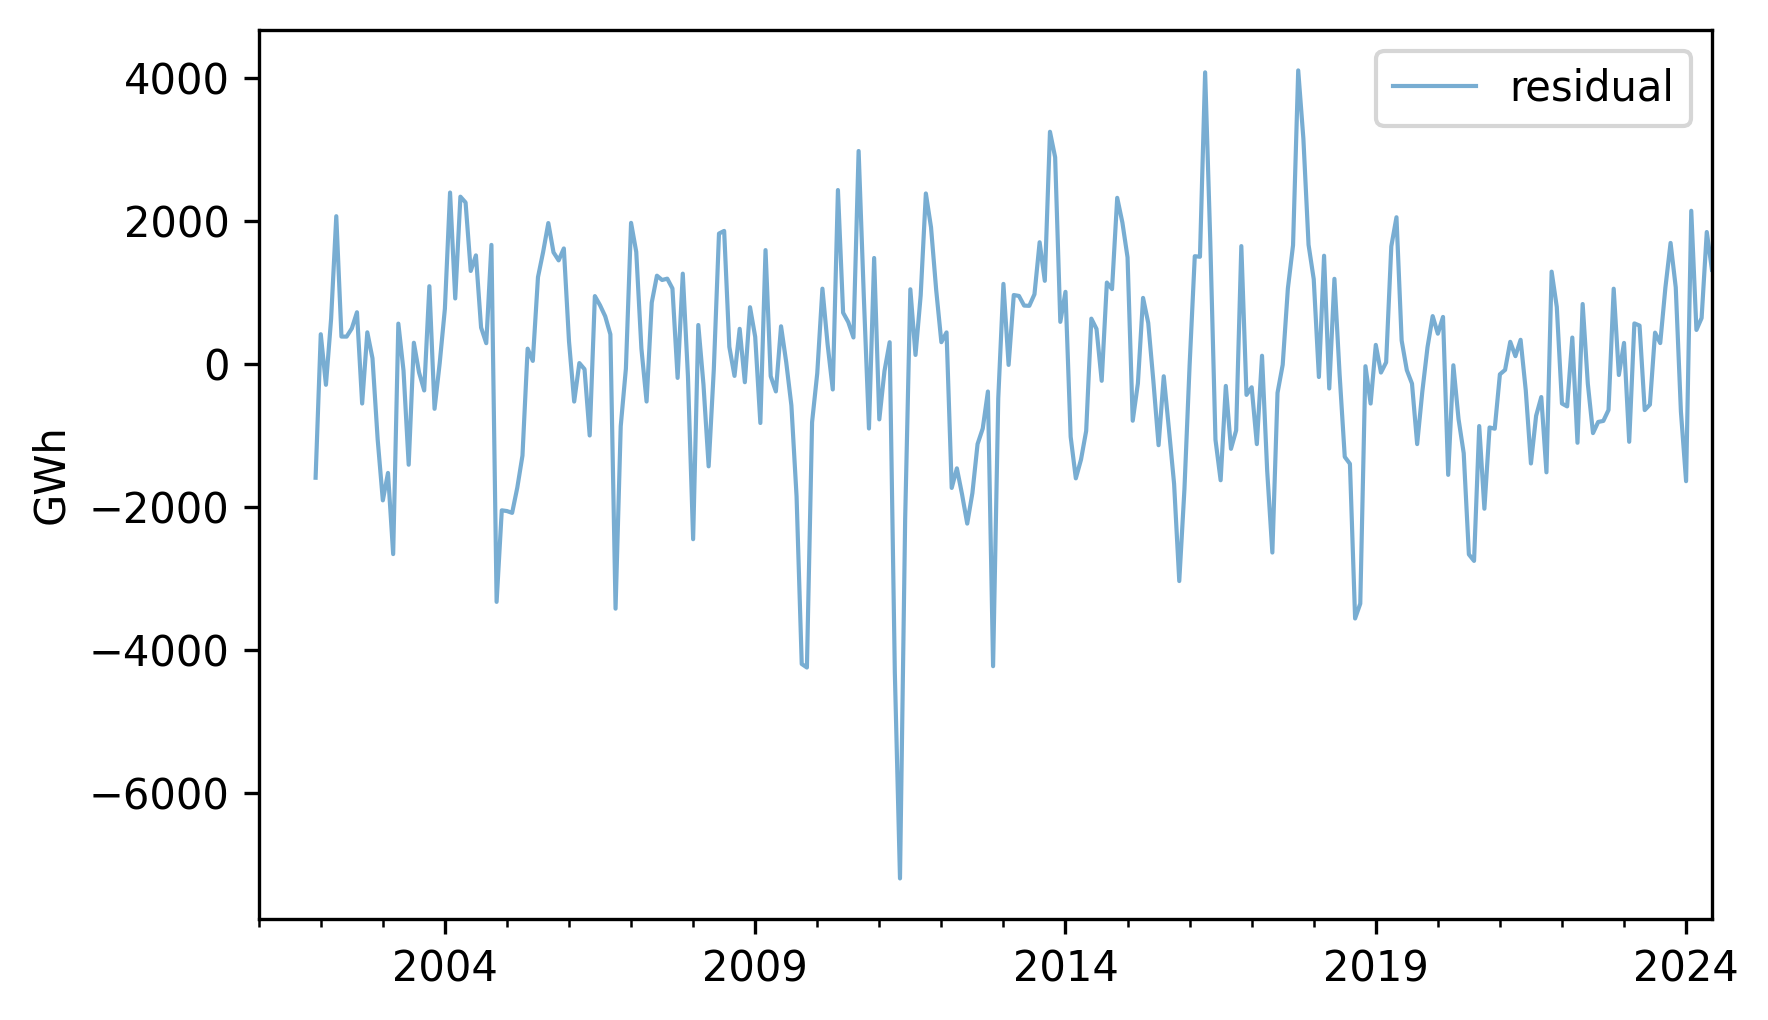

In [18]:
resid = nuclear - expected
resid.plot(label="residual", **actual_options)
decorate(ylabel="GWh")

We can think of the residual as the sum of everything in the world that affects energy production, but is not explained by the long-term trend or the seasonal component.
Among other things, that sum includes weather, equipment that's down for maintenance, and changes in demand due to specific events.
Since the residual is the sum of many unpredictable, and sometimes unknowable, factors, we often treat it as a random quantity.

Here's what the distribution of the residuals look like.

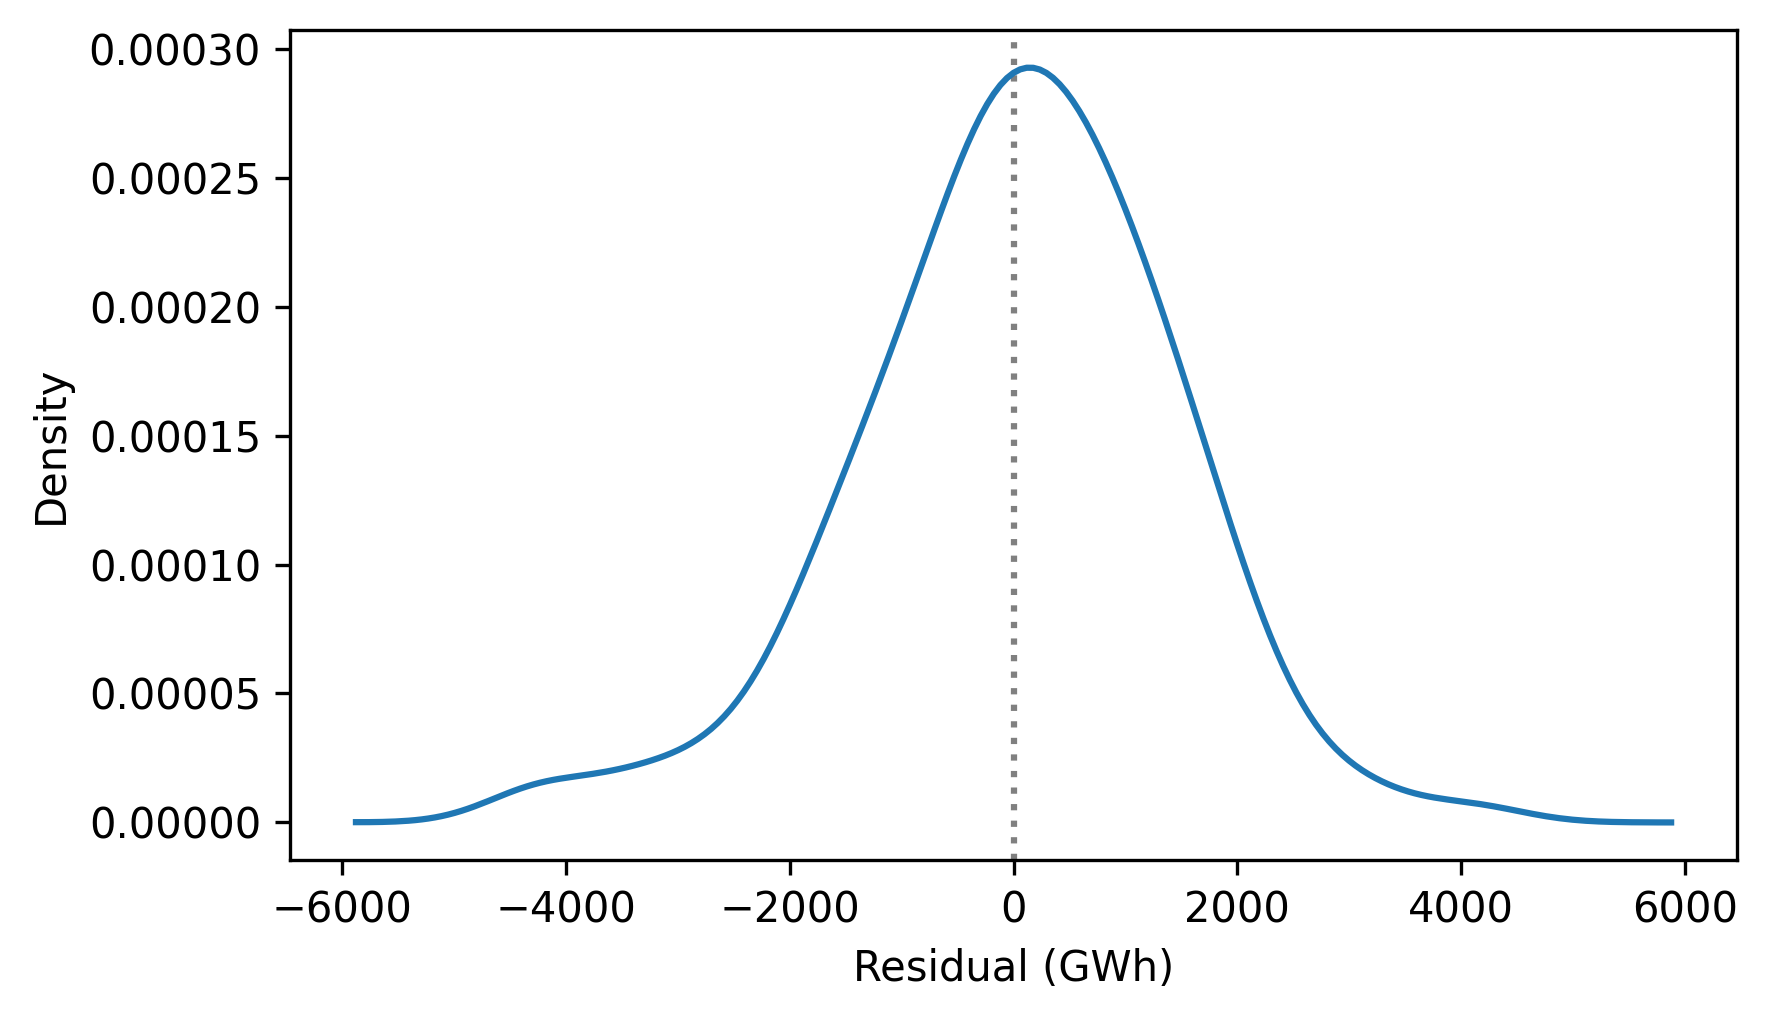

In [19]:
from thinkstats import plot_kde

plot_kde(resid.dropna())
decorate(xlabel="Residual (GWh)", ylabel="Density")

It resembles the bell curve of the normal distribution, which is consistent with the assumption that it is the sum of many random contributions.

To quantify how well this model describes the original series, we can compute the coefficient of determination, which indicates how much smaller the variance of the residuals is, compared to the variance of the original series.

In [20]:
rsquared = 1 - resid.var() / nuclear.var()
rsquared

0.9054559977517084

The $R^2$ value is about 0.92, which means that the long-term trend and seasonal component account for 92% of the variability in the series.
This $R^2$ is substantially higher than the ones we saw in the previous chapter, but that's common with time series data -- especially in a case like this where we've constructed the model to resemble the data.

The process we've just walked through is called **seasonal decomposition**.
StatsModels provides a function that does it, called `seasonal_decompose`.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(nuclear, model="additive", period=12)

The `model="additive"` argument indicates the additive model, so the series is decomposed into the sum of a trend, seasonal component, and residual.
We'll see the multiplicative model soon.
The `period=12` argument indicates that the duration of the seasonal component is 12 months.

The result is an object that contains the three components.
The notebook for this chapter provides a function that plots them.

In [ ]:
def plot_decomposition(original, decomposition):
    plt.figure(figsize=(6, 5))

    ax1 = plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color="C0", lw=1)
    plt.ylabel("Original")

    plt.subplot(4, 1, 2, sharex=ax1)
    plt.plot(decomposition.trend, label="Trend", color="C1", lw=1)
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3, sharex=ax1)
    plt.plot(decomposition.seasonal, label="Seasonal", color="C2", lw=1)
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4, sharex=ax1)
    plt.plot(decomposition.resid, label="Residual", color="C3", lw=1)
    plt.ylabel("Residual")

    plt.tight_layout()

In [ ]:
plot_decomposition(nuclear, decomposition)

The results are similar to those we computed ourselves, with small differences due to the details of the implementation.

This kind of seasonal decomposition provides insight into the structure of a time series.
As we'll see in the next section, it is also useful for making forecasts.

## Prediction

We can use the results from seasonal decomposition to predict the future.
To demonstrate, we'll use the following function to split the time series into a **training series**, which we'll use to generate predictions, and a **test series**, which we'll use to see whether they are accurate.

In [ ]:
def split_series(series, n=60):
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

With `n=60`, the duration of the test series is five years, starting in July 2019.

In [ ]:
training, test = split_series(nuclear)
test.index[0]

Now, suppose it's June 2019 and you are asked to generate a five-year forecast for electricity production from nuclear generators.
To answer this question, we'll use the training data to make a model and then use the model to generate predictions.
We'll start with a seasonal decomposition of the training data.

In [ ]:
decomposition = seasonal_decompose(training, model="additive", period=12)
trend = decomposition.trend

Now we'll fit a linear model to the trend.
The explanatory variable, `months`, is the number of months from the beginning of the series.

In [ ]:
import statsmodels.formula.api as smf

months = np.arange(len(trend))
data = pd.DataFrame({"trend": trend, "months": months}).dropna()
results = smf.ols("trend ~ months", data=data).fit()

Here is a summary of the results.

In [ ]:
from thinkstats import display_summary

display_summary(results)

The $R^2$ value is about 0.35, which suggests that the model does not fit the data particularly well.
We can get a better sense of that by plotting the fitted line.
We'll use the `predict` method to compute expected values for the training and test data.

In [ ]:
months = np.arange(len(training) + len(test))
df = pd.DataFrame({"months": months})
pred_trend = results.predict(df)
pred_trend.index = nuclear.index

Here's the trend component and the linear model.

In [ ]:
trend.plot(**trend_options)
pred_trend.plot(label="linear model", **model_options)
decorate(ylabel="GWh")

There's a lot going on that's not captured by the linear model, but it looks like there is a generally increasing trend.

Next we'll use the seasonal component from the decomposition to compute a `Series` of monthly averages.

In [ ]:
seasonal = decomposition.seasonal
monthly_averages = seasonal.groupby(seasonal.index.month).mean()

We can predict the seasonal component by looking up the dates from the fitted line in `monthly_averages`.

In [ ]:
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index

Finally, to generate predictions, we'll add the seasonal component to the trend.

In [ ]:
pred = pred_trend + pred_seasonal

Here's the training data and the predictions.

In [ ]:
pred.plot(label="prediction", **pred_options)
training.plot(label="training", **actual_options)
decorate(ylabel="GWh")

The predictions fit the training data reasonably well, and the forecast looks like a reasonable projection, based on the assumption that the long-term trend will continue.

Now, from the vantage point of the future, let's see how accurate this forecast turned out to be.
Here are the predicted and actual values for the five-year interval from July 2019.

In [ ]:
forecast = pred[test.index]
forecast.plot(label="predicted", **pred_options)
test.plot(label="actual", **actual_options)
decorate(ylabel="GWh")

The first year of the forecast was pretty good, but production from nuclear reactors in 2020 was lower than expected -- possibly due to the COVID-19 pandemic -- and it never returned to the long-term trend.

To quantify the accuracy of the predictions, we'll use the mean absolute percentage error (MAPE), which the following function computes.

In [ ]:
def MAPE(predicted, actual):
    ape = np.abs(predicted - actual) / actual
    return np.mean(ape) * 100

In this example, the predictions are off by 3.81% on average.

In [ ]:
MAPE(forecast, test)

We'll come back to this example later in the chapter and see if we can do better with a different model.

## Multiplicative Model

The additive model we used in the previous section assumes that the time series is the *sum* of a long-term trend, a seasonal component, and a residual -- which implies that the magnitude of the seasonal component and the residuals does not vary over time.

As an example that violates this assumption, let's look at small-scale solar electricity production since 2014.

In [ ]:
solar = elec["United States : small-scale solar photovoltaic"].dropna()
solar.plot(label="solar", **actual_options)
decorate(ylabel="GWh")

Over this interval, total production has increased several times over.
And it's clear that the magnitude of seasonal variation has increased as well.

If we suppose that the magnitudes of seasonal and random variation are proportional to the magnitude of the trend, that suggests an alternative to the additive model in which the time series is the *product* of the three components.

To try out this multiplicative model, we'll split this series into training and test sets.

In [ ]:
training, test = split_series(solar)

And call `seasonal_decompose` with the `model="multiplicative"` argument.

In [ ]:
decomposition = seasonal_decompose(training, model="multiplicative", period=12)

Here's what the results look like.

In [ ]:
plot_decomposition(training, decomposition)

Now the seasonal and residual components are multiplicative factors.
So, it looks like the seasonal component varies from about 25% below the trend to 25% above.
And the residual component is usually less than 5% either way, with the exception of some larger factors in the first period.
We can extract the components of the model like this.

In [ ]:
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

The $R^2$ value of this model is very high.

In [ ]:
rsquared = 1 - resid.var() / training.var()
rsquared

The production of a solar panel is largely a function of the sunlight it's exposed to, so it makes sense that production follows an annual cycle so closely.

To predict the long term trend, we'll use a quadratic model.

In [ ]:
months = range(len(training))
data = pd.DataFrame({"trend": trend, "months": months}).dropna()
results = smf.ols("trend ~ months + I(months**2)", data=data).fit()

In the Patsy formula, the substring `I(months**2)` adds a quadratic term to the model, so we don't have to compute it explicitly.
Here are the results.

In [ ]:
display_summary(results)

The p-values of the linear and quadratic terms are very small, which suggests that the quadratic model captures more information about the trend than a linear model would -- and the $R^2$ value is very high.

Now we can use the model to compute the expected value of the trend for the past and future.

In [ ]:
months = range(len(solar))
df = pd.DataFrame({"months": months})
pred_trend = results.predict(df)
pred_trend.index = solar.index

Here's what it looks like.

In [ ]:
pred_trend.plot(label="quadratic model", **model_options)
trend.plot(**trend_options)
decorate(ylabel="GWh")

The quadratic model fits the past trend well.
Now we can use the seasonal component to predict future seasonal variation.

In [ ]:
monthly_averages = seasonal.groupby(seasonal.index.month).mean()
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index

Finally, to compute **retrodictions** for past values and predictions for the future, we multiply the trend and the seasonal component.

In [ ]:
pred = pred_trend * pred_seasonal

Here is the result along with the training data.

In [ ]:
training.plot(label="training", **actual_options)
pred.plot(label="prediction", **pred_options)
decorate(ylabel="GWh")

The retrodictions fit the training data well and the predictions seem plausible -- now let's see if they turned out to be accurate.
Here are the predictions along with the test data.

In [ ]:
future = pred[test.index]
future.plot(label="prediction", **pred_options)
test.plot(label="actual", **actual_options)
decorate(ylabel="GWh")

For the first three years, the predictions are very good.
After that, it looks like actual growth exceeded expectations.

In this example, seasonal decomposition worked well for modeling and predicting solar production, but in the previous example, it was not very effective for nuclear production.
In the next section, we'll try a different approach, autoregression.

## Autoregression

The first idea of autoregression is that the future will be like the past.
For example, in the time series we've looked at so far, there is a clear annual cycle.
So if you are asked to make a prediction for next June, a good starting place would be last June.

To see how well that might work, let's go back to `nuclear`, which contains monthly electricity production from nuclear generators, and compute differences between the same month in successive years, which are called "year-over-year" differences.

In [ ]:
diff = (nuclear - nuclear.shift(12)).dropna()
diff.plot(label="year over year differences", **actual_options)
decorate(ylabel="GWh")

The magnitudes of these differences are substantially smaller than the magnitudes of the original series, which suggests the second idea of autoregression, which is that it might be easier to predict these differences, rather than the original values.

Toward that end, let's see if there are correlations between successive elements in the series of differences.
If so, we could use those correlations to predict future values based on previous values.

I'll start by making a `DataFrame`, putting the differences in the first column and putting  the same differences -- shifted by 1, 2, and 3 months -- into successive columns.
These columns are named `lag1`, `lag2`, and `lag3`, because the series they contain have been **lagged** or delayed.

In [ ]:
df_ar = pd.DataFrame({"diff": diff})
for lag in [1, 2, 3]:
    df_ar[f"lag{lag}"] = diff.shift(lag)

df_ar = df_ar.dropna()

Here are the correlations between these columns.

In [ ]:
df_ar.corr()[["diff"]]

These correlations are called lagged correlations or **autocorrelations** -- the prefix "auto" indicates that we're taking the correlation of the series with itself.
As a special case, the correlation between `diff` and `lag1` is called **serial correlation** because it is the correlation between successive elements in the series.

These correlation are strong enough to suggest that they should help with prediction, so let's put them into a multiple regression.
The following function uses the columns from the `DataFrame` to make a Patsy formula with the first column as the response variable and the other columns as explanatory variables.

In [ ]:
def make_formula(df):
    """Make a Patsy formula from column names."""
    y = df.columns[0]
    xs = " + ".join(df.columns[1:])
    return f"{y} ~ {xs}"

Here are the results of a linear model that predicts the next value in a sequence based on the previous three values.

In [ ]:
formula = make_formula(df_ar)
results_ar = smf.ols(formula=formula, data=df_ar).fit()
display_summary(results_ar)

Now we can use the `predict` method to generate predictions for the past values in the series.
Here's what these retrodictions look like compared to the data.

In [ ]:
pred_ar = results_ar.predict(df_ar)
pred_ar.plot(label="predictions", **pred_options)
diff.plot(label="differences", **actual_options)
decorate(ylabel="GWh")

The predictions are good in some places, but the $R^2$ value is only about 0.319, so there is room for improvement.

In [ ]:
resid_ar = (diff - pred_ar).dropna()
R2 = 1 - resid_ar.var() / diff.var()
R2

One way to improve the predictions is to compute the residuals from this model and use another model to predict the residuals -- which is the third idea of autoregression.

## Moving Average

Suppose it's June 2019, and you are asked to make a prediction for June 2020.
Your first guess might be that this year's value will be repeated next year.

Now suppose it's May 2020, and you are asked to revise your prediction for June 2020.
You could use the results from the last three months, and the autocorrelation model from the previous section, to predict the year-over-year difference.

Finally, suppose you check the predictions for the last few months, and see that they have been consistently too low.
That suggests that the prediction for next month might also be too low, so you could revise it upward.
The underlying assumption is that recent prediction errors predict future prediction errors.

To see whether they do, we can make a `DataFrame` with the residuals from the autoregression model in the first column, and lagged versions of the residuals in the other columns.
For this example, I'll use lags of 1 and 6 months.

In [ ]:
df_ma = pd.DataFrame({"resid": resid_ar})

for lag in [1, 6]:
    df_ma[f"lag{lag}"] = resid_ar.shift(lag)

df_ma = df_ma.dropna()

We can use `ols` to make an autoregression model for the residuals.
This part of the model is called a "moving average" because it reduces variability in the predictions in a way that's analogous to the effect of a moving average.
I don't find that term particularly helpful, but it is conventional.

Anyway, here's a summary of the autoregression model for the residuals.

In [ ]:
formula = make_formula(df_ma)
results_ma = smf.ols(formula=formula, data=df_ma).fit()
display_summary(results_ma)

The $R^2$ is quite small, so it looks like this part of the model won't help very much.
But the p-value for the 6-month lag is small, which suggests that it contributes more information than we'd expect by chance.

Now we can use the model to generate retrodictions for the residuals.

In [ ]:
pred_ma = results_ma.predict(df_ma)

Then, to generate retrodictions for the year-over-year differences, we add the adjustment from the second model to the retrodictions from the first.

In [ ]:
pred_diff = pred_ar + pred_ma

The $R^2$ value for the sum of the two models is about 0.332, which is just a little better than the result without the moving average adjustment (0.319).

In [ ]:
resid_ma = (diff - pred_diff).dropna()
R2 = 1 - resid_ma.var() / diff.var()
R2

Next we'll use these year-over-year differences to generate retrodictions for the original values.

## Retrodiction with Autoregression

To generate retrodictions, we'll start by putting the year-over-year differences in a `Series` that's aligned with the index of the original.

In [ ]:
pred_diff = pd.Series(pred_diff, index=nuclear.index)

Using `isna` to check for `NaN` values, we find that the first 21 elements of the new `Series` are missing.

In [ ]:
n_missing = pred_diff.isna().sum()
n_missing

That's because we shifted the `Series` by 12 months to compute year-over-year differences, then we shifted the differences 3 months for the first autoregression model, and we shifted the residuals of the first model by 6 months for the second model.
Each time we shift a `Series` like this, we lose a few values at the beginning, and the sum of these shifts is 21.

So before we can generate retrodictions, we have to prime the pump by copying the first 21 elements from the original into a new `Series`.

In [ ]:
pred_series = pd.Series(index=nuclear.index, dtype=float)
pred_series.iloc[:n_missing] = nuclear.iloc[:n_missing]

Now we can run the following loop, which fills in the elements from index 21 (which is the 22nd element) to the end.
Each element is the sum of the value from the previous year and the predicted year-over-year difference.

In [ ]:
for i in range(n_missing, len(pred_series)):
    pred_series.iloc[i] = pred_series.iloc[i - 12] + pred_diff.iloc[i]

Now we'll replace the elements we copied with `NaN` so we don't get credit for "predicting" the first 21 values perfectly.

In [ ]:
pred_series[:n_missing] = np.nan

Here's what the retrodictions look like compared to the original.

In [ ]:
pred_series.plot(label="predicted", **pred_options)
nuclear.plot(label="actual", **actual_options)
decorate(ylabel="GWh")

They look pretty good, and the $R^2$ value is about 0.86.

In [ ]:
resid = (nuclear - pred_series).dropna()
R2 = 1 - resid.var() / nuclear.var()
R2

The model we used to compute these retrodictions is called SARIMA, which is one of a family of models called ARIMA.
Each part of these acronyms refers to an element of the model.

* **S** stands for seasonal, because the first step was to compute differences between values separated by one seasonal period.

* **AR** stands for autoregression, which we used to model lagged correlations in the differences.

* **I** stands for integrated, because the iterative process we used to compute `pred_series` is analogous to integration in calculus.

* **MA** stands for moving average, which is the conventional name for the second autoregression model we ran with the residuals from the first.

ARIMA models are powerful and versatile tools for modeling time series data.

## ARIMA

StatsModel provides a library called `tsa`, which stands for "time series analysis" -- it includes a function called `ARIMA` that fits ARIMA models and generates forecasts.

To fit the SARIMA model we developed in the previous sections, we'll call this function with two tuples as arguments: `order` and `seasonal_order`.
Here are the values in `order` that correspond to the model we used in the previous sections.

In [ ]:
order = ([1, 2, 3], 0, [1, 6])

The values in `order` indicate:

* Which lags should be included in the AR model -- in this example it's the first three.

* How many times it should compute differences between successive elements -- in this example it's 0 because we computed a seasonal difference instead, and we'll get to that in a minute.

* Which lags should be included in the MA model -- in this example it's the first and sixth.

Now here are the values in `seasonal_order`.

In [ ]:
seasonal_order = (0, 1, 0, 12)

The first and third elements are 0, which means that this model does not include seasonal AR or seasonal MA.
The second element is 1, which means it computes seasonal differences -- and the last element is the seasonal period.

Here's how we use `ARIMA` to make and fit this model.

In [ ]:
import statsmodels.tsa.api as tsa

model = tsa.ARIMA(nuclear, order=order, seasonal_order=seasonal_order)
results_arima = model.fit()
display_summary(results_arima)

The results include estimated coefficients for the three lags in the AR model, the two lags in the MA model, and `sigma2`, which is the variance of the residuals.

From `results_arima` we can extract `fittedvalues`, which contains the retrodictions.
For the same reason there were missing values at the beginning of the retrodictions we computed, there are incorrect values at the beginning of `fittedvalues`, which we'll drop.

In [ ]:
fittedvalues = results_arima.fittedvalues[n_missing:]

The fitted values are similar to the ones we computed, but not exactly the same -- probably because `ARIMA` handles the initial conditions differently.

In [ ]:
fittedvalues.plot(label="ARIMA model", **pred_options)
nuclear.plot(label="actual", **actual_options)
decorate(ylabel="GWh")

The $R^2$ value is also similar but not precisely the same.

In [ ]:
resid = fittedvalues - nuclear
R2 = 1 - resid.var() / nuclear.var()
R2

The `ARIMA` function makes it easy to experiment with different versions of the model.

As an exercise, try out different values in `order` and `seasonal_order` and see if you can  find a model with higher $R^2$.

## Prediction with ARIMA

The object returned by `ARIMA` provides a method called `get_forecast` that generates predictions.
To demonstrate, we'll split the time series into a training and test set, and fit the same model to the training set.

In [ ]:
training, test = split_series(nuclear)
model = tsa.ARIMA(training, order=order, seasonal_order=seasonal_order)
results_training = model.fit()

We can use the result to generate a forecast for the test set.

In [ ]:
forecast = results_training.get_forecast(steps=len(test))

The result is an object that contains an attribute called `forecast_mean` and a function that returns a confidence interval.

In [ ]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_ci.columns = ["lower", "upper"]

We can plot the results like this and compare them to the actual time series.

In [ ]:
plt.fill_between(
    forecast_ci.index,
    forecast_ci.lower,
    forecast_ci.upper,
    lw=0,
    color="gray",
    alpha=0.2,
)
plt.plot(forecast_mean.index, forecast_mean, label="forecast", **pred_options)
plt.plot(test.index, test, label="actual", **actual_options)
decorate(ylabel="GWh")

The actual values fall almost entirely within the confidence interval of the predictions.
Here's the MAPE of the predictions.

In [ ]:
MAPE(forecast_mean, test)

The predictions are off by 3.38% on average, somewhat better than the results we got from seasonal decomposition (3.81%).

ARIMA is more versatile than seasonal decomposition, and can often make better predictions.
In this time series, the autocorrelations are not especially strong, so the advantage of ARIMA is modest.

## Glossary

-   **time series**: A dataset where each value is associated with a specific time, often representing measurements taken at regular intervals.

-   **seasonal decomposition:** A method of splitting a time series into a long-term trend, a repeating seasonal component, and a residual component.

-   **training series:** Part of a time series used to fit a model.

-   **test series:** Part of a time series used to check the accuracy of predictions generated by a model.

-   **retrodiction:** A prediction for a value observed in the past, often used to test or validate a model.

-   **window**: A sequence of consecutive values in a time series, used to compute a moving average.

-   **moving average**: A time series computed by averaging values in overlapping windows to smooth fluctuations.

-   **serial correlation**: The correlation between successive elements of a time series.

-   **autocorrelation**: A correlation between a time series and a shifted or lagged version of itself.

-   **lag**: The size of the shift in a serial correlation or autocorrelation.

## Exercises

### Exercise 12.1

As an example of seasonal decomposition, let's model monthly average surface temperatures in the United States.
We'll use a dataset from Our World in Data that includes "temperature [in Celsius] of the air measured 2 meters above the ground, encompassing land, sea, and in-land water surfaces," for most countries in the world from 1950 to 2024.
Instructions for downloading the data are in the notebook for this chapter.

In [ ]:
# The following cell downloads data prepared by Our World in Data,
# which I Downloaded September 18, 2024
# from https://ourworldindata.org/grapher/average-monthly-surface-temperature

# Based on modified data from Copernicus Climate Change Service information (2019)
# with "major processing" by Our World in Data

In [ ]:
filename = "monthly-average-surface-temperatures-by-year.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

We can read the data like this.

In [ ]:
temp = pd.read_csv("monthly-average-surface-temperatures-by-year.csv")

In [ ]:
temp.head()

The following cell selects data for the United States from 2001 to the end of the series and packs it into a Pandas `Series`.

In [ ]:
temp_us = temp.query("Code == 'USA'")
columns = [str(year) for year in range(2000, 2025)]
temp_series = temp_us.loc[:, columns].transpose().stack()
temp_series.index = pd.date_range(start="2000-01", periods=len(temp_series), freq="ME")

Here's what it looks like.

In [ ]:
temp_series.plot(label="monthly average", **actual_options)
decorate(ylabel="Surface temperature (degC)")

Not surprisingly, there is a strong seasonal pattern.
Compute an additive seasonal decomposition with a period of 12 months.
Fit a linear model to the trend line.
What is the average annual increase in surface temperature during this interval?
If you are curious, repeat this analysis with other intervals or data from other countries.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

### Exercise 12.2

Earlier in this chapter we used a multiplicative seasonal decomposition to model electricity production from small-scale solar power from 2014 to 2019 and forecast production from 2019 to 2024.
Now let's do the same with utility-scale solar power.
Here's what the time series looks like.

In [ ]:
util_solar = elec["United States : all utility-scale solar"].dropna()
util_solar = util_solar[util_solar.index.year >= 2014]
util_solar.plot(**actual_options)
decorate(ylabel="GWh")

Use `split_series` to split this data into a training and test series.
Compute a multiplicative decomposition of the training series with a 12-month period.
Fit a linear or quadratic model to the trend and generate a five-year forecast, including a seasonal component.
Plot the forecast along with the test series, and compute the mean absolute percentage error (MAPE).

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

### Exercise 12.3

Let's see how well an ARIMA model fits production from hydroelectric generators in the United States.
Here's what the time series looks like from 2001 to 2024.

In [ ]:
hydro = elec["United States : conventional hydroelectric"]
hydro.plot(**actual_options)
decorate(ylabel="GWh")

Fit a SARIMA model to this data with a seasonal period of 12 months.
Experiment with different lags in the autoregression and moving average parts of the model and see if you can find a combination that maximizes the $R^2$ value of the model.
Generate a five-year forecast and plot it along with its confidence interval.

NOTE: Depending on what lags you include in the model, you might find that the first 12 to 24 elements of the fitted values are not reliable. You might want to remove them before plotting or computing $R^2$.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)